# Trained on AWS with a p3.2x instance - 16 GB Tesla V100 Graphics Card 
## Final training time: approx 30 hours, for 150 iterations

In [3]:
from glob import glob 
import os, random
import scipy.misc

from collections import namedtuple

import os.path
import tensorflow as tf
import warnings
from distutils.version import LooseVersion
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


import shutil
from urllib.request import urlretrieve
import zipfile
from tqdm import tqdm

####To Download the data on AWS
# !wget url_for_hosted_labels
# !mv downloaded_label_name resized_labels.zip #rename to a zip folder 
# !unzip resized_labels

# !wget url_for_hosted_data
# !mv downloaded_data_name resized_dataset.zip
# !unzip resized_dataset


#### ---------------------------------------------------####
#### Download the VGG Model
#### ---------------------------------------------------####

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num


def maybe_download_pretrained_vgg(data_dir):
    """
    Download and extract pretrained vgg model if it doesn't exist
    :param data_dir: Directory to download the model to
    """
    vgg_filename = 'vgg.zip'
    vgg_path = os.path.join(data_dir, 'vgg')
    vgg_files = [
        os.path.join(vgg_path, 'variables/variables.data-00000-of-00001'),
        os.path.join(vgg_path, 'variables/variables.index'),
        os.path.join(vgg_path, 'saved_model.pb')]

    missing_vgg_files = [vgg_file for vgg_file in vgg_files if not os.path.exists(vgg_file)]
    if missing_vgg_files:
        # Clean vgg dir
        if os.path.exists(vgg_path):
            shutil.rmtree(vgg_path)
        os.makedirs(vgg_path)

        # Download vgg
        print('Downloading pre-trained vgg model...')
        with DLProgress(unit='B', unit_scale=True, miniters=1) as pbar:
            urlretrieve(
                'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/vgg.zip',
                os.path.join(vgg_path, vgg_filename),
                pbar.hook)

        # Extract vgg
        print('Extracting model...')
        zip_ref = zipfile.ZipFile(os.path.join(vgg_path, vgg_filename), 'r')
        zip_ref.extractall(data_dir)
        zip_ref.close()

        # Remove zip file to save space
        os.remove(os.path.join(vgg_path, vgg_filename))

#### ---------------------------------------------------####
#### How the segments are colored in the labels
#### ---------------------------------------------------####
#Retrieved from https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
Label = namedtuple( 'Label' , ['name','color'] )
labels_Segments = [
    #       name                       color
    Label(  'unlabeled'            , (  0,  0,  0) ),
    Label(  'dynamic'              , (111, 74,  0) ),
    Label(  'ground'               , ( 81,  0, 81) ),
    Label(  'road'                 , (128, 64,128) ),
    Label(  'sidewalk'             , (244, 35,232) ),
    Label(  'parking'              , (250,170,160) ),
    Label(  'rail track'           , (230,150,140) ),
    Label(  'building'             , ( 70, 70, 70) ),
    Label(  'wall'                 , (102,102,156) ),
    Label(  'fence'                , (190,153,153) ),
    Label(  'guard rail'           , (180,165,180) ),
    Label(  'bridge'               , (150,100,100) ),
    Label(  'tunnel'               , (150,120, 90) ),
    Label(  'pole'                 , (153,153,153) ),
    Label(  'traffic light'        , (250,170, 30) ),
    Label(  'traffic sign'         , (220,220,  0) ),
    Label(  'vegetation'           , (107,142, 35) ),
    Label(  'terrain'              , (152,251,152) ),
    Label(  'sky'                  , ( 70,130,180) ),
    Label(  'person'               , (220, 20, 60) ),
    Label(  'rider'                , (255,  0,  0) ),
    Label(  'car'                  , (  0,  0,142) ),
    Label(  'truck'                , (  0,  0, 70) ),
    Label(  'bus'                  , (  0, 60,100) ),
    Label(  'caravan'              , (  0,  0, 90) ),
    Label(  'trailer'              , (  0,  0,110) ),
    Label(  'train'                , (  0, 80,100) ),
    Label(  'motorcycle'           , (  0,  0,230) ),
    Label(  'bicycle'              , (119, 11, 32) ),
]
        
    
#### ---------------------------------------------------####
#### Data Generators for training and validations
#### ---------------------------------------------------####
def gen_batch_function(data_folder, label_folder, labels):
    def get_batches_fn(batch_size):
        
        
        image_paths = glob(os.path.join(data_folder, '**', '*.png'))
        label_paths = {os.path.basename(path).replace('gtFine_color','leftImg8bit'): path
                       for path in glob(os.path.join(label_folder, '**', '*color.png'))}
        random.shuffle(image_paths)
        for batch_i in range(0, len(image_paths), batch_size):
            images = []
            gt_images = []

            for image_file in image_paths[batch_i:batch_i+batch_size]:
                gt_image_file = label_paths[os.path.basename(image_file)]

                #image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape) Already Resized
                #gt_image = scipy.misc.imresize(scipy.misc.imread(gt_image_file), image_shape) Already Resized

                image = scipy.misc.imread(image_file)
                gt_image = scipy.misc.imread(gt_image_file)

                label_list = np.zeros((gt_image.shape[0],gt_image.shape[1],len(labels)))
                background_label = np.zeros((gt_image.shape[0],gt_image.shape[1]), dtype=bool)
                for idx,labl in enumerate(labels[1:]):
                    current_mask = np.all(gt_image == labl.color, axis = 2)
                    
                    label_list[:,:,idx+1] = np.array(current_mask)
                    background_label = background_label | current_mask

                background_label = np.invert(background_label)
                label_list[:,:,0] = background_label
                
                images.append(image.astype(np.float32))
                gt_images.append(label_list)

            yield np.array(images), np.array(gt_images)
    return get_batches_fn
        

In [10]:
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))


def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'
    
    tf.saved_model.loader.load(sess, ['vgg16'], vgg_path)
    graph = tf.get_default_graph()
    image_input = graph.get_tensor_by_name(vgg_input_tensor_name)
    keep_prob = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    layer3 = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    layer4 = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    layer7 = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)
    
    return image_input, keep_prob, layer3, layer4, layer7


def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer7_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer3_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    
    kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3)
    kernel_initializer=tf.truncated_normal_initializer(stddev=0.01)
    
    
    conv1x1= tf.layers.conv2d(vgg_layer7_out, filters = num_classes,kernel_size=1, strides = (1,1), padding = 'same',
                             kernel_regularizer=kernel_regularizer,kernel_initializer = kernel_initializer)
    up_sampled_1 = tf.layers.conv2d_transpose(conv1x1, num_classes,4, 2, padding='same',
                              kernel_regularizer=kernel_regularizer,kernel_initializer = kernel_initializer)
    #adding the skipped connections
    
    vgg_layer4_1x1 = tf.layers.conv2d(vgg_layer4_out, num_classes,1, strides=(1,1), padding= 'same',
                             kernel_regularizer=kernel_regularizer,kernel_initializer = kernel_initializer)

    skip_1 = tf.add(up_sampled_1, vgg_layer4_1x1)
    
    up_sampled_2 = tf.layers.conv2d_transpose(skip_1, num_classes,4,2, padding='same',
                             kernel_regularizer=kernel_regularizer,kernel_initializer = kernel_initializer)
    
    vgg_layer3_1x1 = tf.layers.conv2d(vgg_layer3_out, num_classes,1, strides=(1,1), padding= 'same',
                             kernel_regularizer=kernel_regularizer,kernel_initializer = kernel_initializer)
    skip_2 = tf.add(up_sampled_2, vgg_layer3_1x1)
    
    up_sampled_3 = tf.layers.conv2d_transpose(skip_2, num_classes, 16,8, padding= 'same',
                                             kernel_regularizer=kernel_regularizer,kernel_initializer = kernel_initializer)
    
    return up_sampled_3


def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    logits = tf.reshape(nn_last_layer, (-1, num_classes), name = 'logits')
    softmax_on_logits = tf.nn.softmax(logits,name = 'softmax') #used for inference

    labels_reshaped = tf.reshape(correct_label, (-1, num_classes))
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels= labels_reshaped))
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    
    training_operation = optimizer.minimize(cross_entropy_loss)
    
    return logits, training_operation, cross_entropy_loss


TensorFlow Version: 1.4.0-rc0
Default GPU Device: /device:GPU:0


In [11]:
#### ---------------------------------------------------####
#### Conducting First Training, Saving Checkpoints Every 5 Epochs and a final model
#### ---------------------------------------------------####
train_loss_list = [] #to keep track of train loss
valid_loss_list = [] #to keep track of valid loss

num_classes = 29
image_shape = (256, 512)
epochs = 75
#learning_rate = tf.placeholder(tf.float32)

batch_size = 32
correct_label = tf.placeholder(tf.int64, (None,None,None, num_classes),name = 'correct_label')
data_dir = 'resized_dataset/'
label_dir = 'resized_labels/'
l_r = 0.0001


# Download pretrained vgg model
maybe_download_pretrained_vgg(data_dir)

with tf.Session() as sess:
    

    # Path to vgg model
    vgg_path = os.path.join(data_dir, 'vgg')
    # Create function to get batches
    get_batches_fn = gen_batch_function(os.path.join(data_dir, 'train'), os.path.join(label_dir, 'train'), labels_Segments)
    get_batches_fn_valid = gen_batch_function(os.path.join(data_dir, 'val'), os.path.join(label_dir, 'val'), labels_Segments)

    # OPTIONAL: Augment Images for better results
    #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

    # Build NN using load_vgg, layers, and optimize function
    image_input, keep_prob, layer3, layer4, layer7 = load_vgg(sess, vgg_path)
    nn_last_layer = layers(layer3, layer4, layer7, num_classes)
    logits, train_op, cross_entropy_loss = optimize(nn_last_layer, correct_label, l_r, num_classes)

    #  Train NN using 
    kp_pr = 0.5
    sess.run(tf.global_variables_initializer())
    tf.add_to_collection("optimizer", train_op)

    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    
    for i in range(epochs):

        ###----------------------------
        ###Training
        ###----------------------------
        mean_train_loss = 0
        m_train = 0
        tic = time.time()
        for images, labels in get_batches_fn(batch_size):
            _, train_loss = sess.run([train_op, cross_entropy_loss], feed_dict ={image_input:images, correct_label:labels, keep_prob:kp_pr})
            mean_train_loss += train_loss * images.shape[0]
            m_train +=  images.shape[0]
            print("*     Train cost =", "{:.9f}".format(train_loss))
        mean_train_loss /= m_train
        train_loss_list.append(mean_train_loss)
        print("Training Epoch:", '%04d | ' % (i+1), "cost =", "{:.9f}".format(mean_train_loss))
        toc = time.time()
        print(toc-tic)

        ###----------------------------
        ###Validation
        ###----------------------------
        mean_valid_loss = 0
        m_valid = 0
        tic = time.time()
        for images, labels in get_batches_fn_valid(batch_size):
            valid_loss = sess.run([cross_entropy_loss], feed_dict ={image_input:images, correct_label:labels, keep_prob:kp_pr})
            mean_valid_loss += valid_loss[0] * images.shape[0]
            m_valid +=  images.shape[0]
        mean_valid_loss /= m_valid
        valid_loss_list.append(mean_valid_loss)
        print("Validation Epoch:", '%04d | ' % (i+1), "cost =", "{:.9f}".format(mean_valid_loss))
        toc = time.time()
        print(toc-tic)

        if i % 5 == 0:
            checkpoint = '{}/e{}.ckpt'.format('saved_models', i+1)
            saver.save(sess, checkpoint)
            print("Checkpoint saved for epoch "+str(i+1))


    print(m_train, m_valid)
    tf.train.write_graph(sess.graph_def,'saved_models_pb/','FCNVGG.pb', as_text=False)
    saver.save(sess, 'saved_models_pb/FCNVGG')
    
    pd.DataFrame([train_loss_list, valid_loss_list]).T.to_csv('train_valid_initial_training.csv')

    

INFO:tensorflow:Restoring parameters from b'resized_dataset/vgg/variables/variables'
*     Train cost = 11.289482117
*     Train cost = 8.475089073
*     Train cost = 6.812955379
*     Train cost = 6.001025200
*     Train cost = 5.144576073
*     Train cost = 4.602478027
*     Train cost = 4.254923344
*     Train cost = 3.937397480
*     Train cost = 3.708011150
*     Train cost = 3.566879272
*     Train cost = 3.439883232
*     Train cost = 3.339025974
*     Train cost = 3.251456976
*     Train cost = 3.200349331
*     Train cost = 3.096558571
*     Train cost = 3.039412975
*     Train cost = 2.952544928
*     Train cost = 2.920100689
*     Train cost = 2.842350006
*     Train cost = 2.764478683
*     Train cost = 2.770001650
*     Train cost = 2.635060072
*     Train cost = 2.643204689
*     Train cost = 2.592116833
*     Train cost = 2.453618050
*     Train cost = 2.442804813
*     Train cost = 2.388891220
*     Train cost = 2.309804440
*     Train cost = 2.231168985
*     Train cos

*     Train cost = 0.759120822
*     Train cost = 0.814366877
*     Train cost = 0.807156742
*     Train cost = 0.698030114
*     Train cost = 0.676814675
*     Train cost = 0.806683779
*     Train cost = 0.716259837
*     Train cost = 0.757959247
*     Train cost = 0.745122969
*     Train cost = 0.807284296
*     Train cost = 0.781712890
*     Train cost = 0.865440786
*     Train cost = 0.679273009
*     Train cost = 0.739991307
*     Train cost = 0.801315606
*     Train cost = 0.721681833
*     Train cost = 0.833547115
*     Train cost = 0.860184014
*     Train cost = 0.836756170
*     Train cost = 0.750192523
*     Train cost = 0.694668770
*     Train cost = 0.773499131
*     Train cost = 0.700835943
*     Train cost = 0.810573518
*     Train cost = 0.741525233
*     Train cost = 0.690491199
Training Epoch: 0003 |  cost = 0.799592626
542.0371055603027
Validation Epoch: 0003 |  cost = 0.803838314
83.35427403450012
*     Train cost = 0.775856853
*     Train cost = 0.734859169
*     Tr

*     Train cost = 0.602927625
*     Train cost = 0.598575175
*     Train cost = 0.754215837
*     Train cost = 0.548834503
*     Train cost = 0.539078772
*     Train cost = 0.701104403
*     Train cost = 0.661076427
*     Train cost = 0.670780480
*     Train cost = 0.541025639
*     Train cost = 0.527684748
*     Train cost = 0.601852536
*     Train cost = 0.573586702
*     Train cost = 0.570574105
*     Train cost = 0.593384206
*     Train cost = 0.702467561
*     Train cost = 0.651365697
*     Train cost = 0.634357631
*     Train cost = 0.720407903
*     Train cost = 0.606708527
*     Train cost = 0.595242321
*     Train cost = 0.653345883
*     Train cost = 0.614052653
*     Train cost = 0.564654469
*     Train cost = 0.591248810
*     Train cost = 0.687667310
*     Train cost = 0.631410599
*     Train cost = 0.654046893
*     Train cost = 0.673038542
*     Train cost = 0.580616891
*     Train cost = 0.667659879
*     Train cost = 0.631297827
*     Train cost = 0.626645088
*     Tr

*     Train cost = 0.510691226
*     Train cost = 0.560794950
*     Train cost = 0.605484605
*     Train cost = 0.550760090
*     Train cost = 0.585218430
*     Train cost = 0.474787921
*     Train cost = 0.513786435
*     Train cost = 0.558034599
*     Train cost = 0.491240472
*     Train cost = 0.533757448
*     Train cost = 0.538446426
*     Train cost = 0.498098850
*     Train cost = 0.504669547
*     Train cost = 0.519055903
*     Train cost = 0.527555346
*     Train cost = 0.571404576
*     Train cost = 0.562736571
*     Train cost = 0.600990474
*     Train cost = 0.535493016
*     Train cost = 0.544363856
*     Train cost = 0.568593621
*     Train cost = 0.542289674
*     Train cost = 0.487771899
*     Train cost = 0.588924468
*     Train cost = 0.541880012
*     Train cost = 0.615274131
*     Train cost = 0.613711834
*     Train cost = 0.562109172
*     Train cost = 0.521602988
*     Train cost = 0.565382183
*     Train cost = 0.559221089
*     Train cost = 0.490413487
*     Tr

*     Train cost = 0.545477867
*     Train cost = 0.508345902
*     Train cost = 0.440868199
*     Train cost = 0.576957703
*     Train cost = 0.505592763
*     Train cost = 0.453265071
*     Train cost = 0.480426550
*     Train cost = 0.486723185
Training Epoch: 0011 |  cost = 0.498663671
551.9028968811035
Validation Epoch: 0011 |  cost = 0.549304805
85.31736135482788
Checkpoint saved for epoch 11
*     Train cost = 0.474962950
*     Train cost = 0.502761781
*     Train cost = 0.500953853
*     Train cost = 0.455875695
*     Train cost = 0.484744430
*     Train cost = 0.493716747
*     Train cost = 0.393261313
*     Train cost = 0.416881263
*     Train cost = 0.499676764
*     Train cost = 0.481909633
*     Train cost = 0.436626166
*     Train cost = 0.490547597
*     Train cost = 0.545887649
*     Train cost = 0.478183210
*     Train cost = 0.471258104
*     Train cost = 0.516515970
*     Train cost = 0.542279005
*     Train cost = 0.474663973
*     Train cost = 0.481161594
*     Tra

*     Train cost = 0.421668857
*     Train cost = 0.423491627
*     Train cost = 0.436461478
*     Train cost = 0.424360693
*     Train cost = 0.420608342
*     Train cost = 0.463633925
*     Train cost = 0.408030778
*     Train cost = 0.417157829
*     Train cost = 0.428805381
*     Train cost = 0.435038745
*     Train cost = 0.449114501
*     Train cost = 0.406052113
*     Train cost = 0.400343537
*     Train cost = 0.377209663
*     Train cost = 0.416493952
*     Train cost = 0.454837412
*     Train cost = 0.535634875
*     Train cost = 0.416439563
*     Train cost = 0.421245247
*     Train cost = 0.458909035
*     Train cost = 0.462326050
*     Train cost = 0.524652958
*     Train cost = 0.444645166
*     Train cost = 0.433367312
*     Train cost = 0.420212001
*     Train cost = 0.455107987
*     Train cost = 0.433759153
*     Train cost = 0.489640057
*     Train cost = 0.480603695
*     Train cost = 0.426440299
*     Train cost = 0.437931091
*     Train cost = 0.530724466
*     Tr

*     Train cost = 0.432791263
*     Train cost = 0.429277033
*     Train cost = 0.418368399
*     Train cost = 0.386043191
*     Train cost = 0.378547609
*     Train cost = 0.419324934
*     Train cost = 0.428004831
*     Train cost = 0.449983746
*     Train cost = 0.414007336
*     Train cost = 0.425470024
*     Train cost = 0.401592225
*     Train cost = 0.415532321
*     Train cost = 0.406810910
*     Train cost = 0.440555990
*     Train cost = 0.438072026
*     Train cost = 0.420845807
*     Train cost = 0.455412269
*     Train cost = 0.385493964
*     Train cost = 0.382101357
*     Train cost = 0.415355861
*     Train cost = 0.425410241
*     Train cost = 0.419712245
*     Train cost = 0.407565475
*     Train cost = 0.403817624
*     Train cost = 0.440378577
*     Train cost = 0.420449078
*     Train cost = 0.388503760
*     Train cost = 0.374686003
*     Train cost = 0.365783334
*     Train cost = 0.378193319
*     Train cost = 0.411521792
*     Train cost = 0.444353044
*     Tr

*     Train cost = 0.369969606
*     Train cost = 0.389836907
*     Train cost = 0.384832054
*     Train cost = 0.382824242
*     Train cost = 0.378890872
*     Train cost = 0.386228353
*     Train cost = 0.390863121
*     Train cost = 0.393602699
*     Train cost = 0.318221718
*     Train cost = 0.372280002
*     Train cost = 0.348480880
*     Train cost = 0.357194841
*     Train cost = 0.353711158
*     Train cost = 0.363527119
*     Train cost = 0.401708841
*     Train cost = 0.333016992
*     Train cost = 0.357791156
*     Train cost = 0.351932138
*     Train cost = 0.360088348
*     Train cost = 0.366268128
*     Train cost = 0.353247017
*     Train cost = 0.389198273
*     Train cost = 0.398320556
*     Train cost = 0.383731127
*     Train cost = 0.370750248
*     Train cost = 0.344204515
*     Train cost = 0.376734018
*     Train cost = 0.332275391
*     Train cost = 0.374436408
*     Train cost = 0.334730148
*     Train cost = 0.365934163
*     Train cost = 0.350056380
*     Tr

*     Train cost = 0.396439284
*     Train cost = 0.321208149
*     Train cost = 0.371890664
*     Train cost = 0.342801869
*     Train cost = 0.362484217
*     Train cost = 0.306286007
*     Train cost = 0.352899194
*     Train cost = 0.352058530
*     Train cost = 0.351757348
*     Train cost = 0.364254922
*     Train cost = 0.350372523
*     Train cost = 0.324918389
*     Train cost = 0.338018298
*     Train cost = 0.359227747
*     Train cost = 0.361986458
*     Train cost = 0.340667486
*     Train cost = 0.353527069
*     Train cost = 0.372453809
Training Epoch: 0022 |  cost = 0.351960445
552.4937431812286
Validation Epoch: 0022 |  cost = 0.511100283
85.18258619308472
*     Train cost = 0.319386005
*     Train cost = 0.337858617
*     Train cost = 0.344977766
*     Train cost = 0.359209478
*     Train cost = 0.328629225
*     Train cost = 0.321239173
*     Train cost = 0.346475899
*     Train cost = 0.383526176
*     Train cost = 0.338161916
*     Train cost = 0.318936884
*     Tr

*     Train cost = 0.349131376
*     Train cost = 0.340276569
*     Train cost = 0.325208664
*     Train cost = 0.335511327
*     Train cost = 0.326817870
*     Train cost = 0.332215905
*     Train cost = 0.339896739
*     Train cost = 0.331686854
*     Train cost = 0.308471560
*     Train cost = 0.314042151
*     Train cost = 0.341959596
*     Train cost = 0.298969477
*     Train cost = 0.307528377
*     Train cost = 0.361222804
*     Train cost = 0.341814578
*     Train cost = 0.354575515
*     Train cost = 0.317403257
*     Train cost = 0.302853137
*     Train cost = 0.343181342
*     Train cost = 0.310498953
*     Train cost = 0.315542072
*     Train cost = 0.311403126
*     Train cost = 0.315976948
*     Train cost = 0.342796177
*     Train cost = 0.324026227
*     Train cost = 0.310428470
*     Train cost = 0.330288529
*     Train cost = 0.311708272
*     Train cost = 0.314526260
*     Train cost = 0.326756895
*     Train cost = 0.312193364
*     Train cost = 0.292105108
*     Tr

*     Train cost = 0.264588416
*     Train cost = 0.302500665
*     Train cost = 0.282612175
*     Train cost = 0.301827818
*     Train cost = 0.281768352
*     Train cost = 0.269505024
*     Train cost = 0.311646819
*     Train cost = 0.301210105
*     Train cost = 0.306762159
*     Train cost = 0.303443015
*     Train cost = 0.308744490
*     Train cost = 0.340628475
*     Train cost = 0.286602020
*     Train cost = 0.293955743
*     Train cost = 0.310629249
*     Train cost = 0.284411937
*     Train cost = 0.252395004
*     Train cost = 0.296757370
*     Train cost = 0.310284764
*     Train cost = 0.321590483
*     Train cost = 0.294780701
*     Train cost = 0.336484998
*     Train cost = 0.290187508
*     Train cost = 0.315520376
*     Train cost = 0.272808582
*     Train cost = 0.291369468
*     Train cost = 0.301560014
*     Train cost = 0.291586667
*     Train cost = 0.289396465
*     Train cost = 0.294265091
*     Train cost = 0.306897491
*     Train cost = 0.300139070
*     Tr

Validation Epoch: 0030 |  cost = 0.531128725
85.08143925666809
*     Train cost = 0.290174454
*     Train cost = 0.254754961
*     Train cost = 0.281362146
*     Train cost = 0.241898715
*     Train cost = 0.270851344
*     Train cost = 0.264456332
*     Train cost = 0.274210542
*     Train cost = 0.270482659
*     Train cost = 0.296605408
*     Train cost = 0.295951962
*     Train cost = 0.282386810
*     Train cost = 0.262322158
*     Train cost = 0.284332931
*     Train cost = 0.244704545
*     Train cost = 0.252086997
*     Train cost = 0.254766852
*     Train cost = 0.258830756
*     Train cost = 0.275726885
*     Train cost = 0.282208681
*     Train cost = 0.261896014
*     Train cost = 0.263566494
*     Train cost = 0.269374192
*     Train cost = 0.303611457
*     Train cost = 0.301050305
*     Train cost = 0.288746715
*     Train cost = 0.280343324
*     Train cost = 0.292783678
*     Train cost = 0.280551314
*     Train cost = 0.271557808
*     Train cost = 0.288734108
*     T

*     Train cost = 0.253424168
*     Train cost = 0.282849580
*     Train cost = 0.253248155
*     Train cost = 0.284731984
*     Train cost = 0.260780782
*     Train cost = 0.254718095
*     Train cost = 0.258570880
*     Train cost = 0.248619944
*     Train cost = 0.264809847
*     Train cost = 0.250244975
*     Train cost = 0.263824940
*     Train cost = 0.239444017
*     Train cost = 0.259262115
*     Train cost = 0.261137903
*     Train cost = 0.242909923
*     Train cost = 0.274614096
*     Train cost = 0.258733690
*     Train cost = 0.252046138
*     Train cost = 0.256815374
*     Train cost = 0.263087392
*     Train cost = 0.264653474
*     Train cost = 0.283706248
*     Train cost = 0.249625355
*     Train cost = 0.276130259
*     Train cost = 0.265375882
Training Epoch: 0033 |  cost = 0.258127962
550.796792268753
Validation Epoch: 0033 |  cost = 0.546278639
85.05201840400696
*     Train cost = 0.247629926
*     Train cost = 0.256765991
*     Train cost = 0.238622665
*     Tra

*     Train cost = 0.248274818
*     Train cost = 0.235369667
*     Train cost = 0.266566485
*     Train cost = 0.229271203
*     Train cost = 0.240946233
*     Train cost = 0.227361396
*     Train cost = 0.226286784
*     Train cost = 0.241312310
*     Train cost = 0.231550768
*     Train cost = 0.238129675
*     Train cost = 0.259234816
*     Train cost = 0.244329572
*     Train cost = 0.233170837
*     Train cost = 0.222778648
*     Train cost = 0.246022820
*     Train cost = 0.263969779
*     Train cost = 0.231818408
*     Train cost = 0.246388048
*     Train cost = 0.244869992
*     Train cost = 0.230953768
*     Train cost = 0.236667588
*     Train cost = 0.247065261
*     Train cost = 0.248280630
*     Train cost = 0.213322103
*     Train cost = 0.216063380
*     Train cost = 0.241103917
*     Train cost = 0.234408364
*     Train cost = 0.255372584
*     Train cost = 0.262558073
*     Train cost = 0.239573538
*     Train cost = 0.241934210
*     Train cost = 0.254134417
*     Tr

*     Train cost = 0.239246786
*     Train cost = 0.248346865
*     Train cost = 0.223899871
*     Train cost = 0.233835340
*     Train cost = 0.251153916
*     Train cost = 0.224337101
*     Train cost = 0.237399936
*     Train cost = 0.229670241
*     Train cost = 0.239785448
*     Train cost = 0.231495872
*     Train cost = 0.226304531
*     Train cost = 0.220866859
*     Train cost = 0.220794290
*     Train cost = 0.228566736
*     Train cost = 0.227440089
*     Train cost = 0.235281676
*     Train cost = 0.213658407
*     Train cost = 0.216943115
*     Train cost = 0.246672541
*     Train cost = 0.236360878
*     Train cost = 0.208078772
*     Train cost = 0.206600934
*     Train cost = 0.225694329
*     Train cost = 0.233787373
*     Train cost = 0.245145187
*     Train cost = 0.251608551
*     Train cost = 0.242840618
*     Train cost = 0.237513065
*     Train cost = 0.214841366
*     Train cost = 0.214094222
*     Train cost = 0.244015053
*     Train cost = 0.241211653
*     Tr

*     Train cost = 0.273964465
*     Train cost = 0.267601937
*     Train cost = 0.262990117
*     Train cost = 0.279715031
*     Train cost = 0.316361248
*     Train cost = 0.282720983
*     Train cost = 0.278861344
Training Epoch: 0041 |  cost = 0.265408231
552.2865114212036
Validation Epoch: 0041 |  cost = 0.495033166
85.54225492477417
Checkpoint saved for epoch 41
*     Train cost = 0.272078216
*     Train cost = 0.312180787
*     Train cost = 0.293574482
*     Train cost = 0.275735259
*     Train cost = 0.245090127
*     Train cost = 0.262588292
*     Train cost = 0.270406872
*     Train cost = 0.251945257
*     Train cost = 0.274401069
*     Train cost = 0.245876938
*     Train cost = 0.299553305
*     Train cost = 0.309189737
*     Train cost = 0.269028127
*     Train cost = 0.289216667
*     Train cost = 0.256597638
*     Train cost = 0.286879122
*     Train cost = 0.295190871
*     Train cost = 0.243147939
*     Train cost = 0.290898442
*     Train cost = 0.266987622
*     Tra

*     Train cost = 0.214433089
*     Train cost = 0.201911226
*     Train cost = 0.209534362
*     Train cost = 0.204072550
*     Train cost = 0.224182576
*     Train cost = 0.211252972
*     Train cost = 0.210203916
*     Train cost = 0.193135753
*     Train cost = 0.206945643
*     Train cost = 0.206081539
*     Train cost = 0.199529350
*     Train cost = 0.209685341
*     Train cost = 0.203175560
*     Train cost = 0.201463938
*     Train cost = 0.198590189
*     Train cost = 0.201120749
*     Train cost = 0.218217209
*     Train cost = 0.214534357
*     Train cost = 0.208059967
*     Train cost = 0.196843743
*     Train cost = 0.196379915
*     Train cost = 0.208182022
*     Train cost = 0.198979929
*     Train cost = 0.226512551
*     Train cost = 0.192518085
*     Train cost = 0.195989877
*     Train cost = 0.203500628
*     Train cost = 0.200573057
*     Train cost = 0.206717268
*     Train cost = 0.202695668
*     Train cost = 0.220936865
*     Train cost = 0.213571116
*     Tr

*     Train cost = 0.199027434
*     Train cost = 0.217853591
*     Train cost = 0.200247735
*     Train cost = 0.192261592
*     Train cost = 0.206138983
*     Train cost = 0.184896007
*     Train cost = 0.195242226
*     Train cost = 0.207476050
*     Train cost = 0.197487429
*     Train cost = 0.189138517
*     Train cost = 0.214408621
*     Train cost = 0.200550437
*     Train cost = 0.196041152
*     Train cost = 0.190685406
*     Train cost = 0.201881334
*     Train cost = 0.203809455
*     Train cost = 0.202374429
*     Train cost = 0.205173135
*     Train cost = 0.190828964
*     Train cost = 0.205765843
*     Train cost = 0.210653752
*     Train cost = 0.196905181
*     Train cost = 0.197572395
*     Train cost = 0.193065211
*     Train cost = 0.201294914
*     Train cost = 0.196074098
*     Train cost = 0.196355417
*     Train cost = 0.196675926
*     Train cost = 0.197391376
*     Train cost = 0.203942344
*     Train cost = 0.205424756
*     Train cost = 0.179045305
*     Tr

*     Train cost = 0.192283779
*     Train cost = 0.183626696
*     Train cost = 0.192253262
*     Train cost = 0.171885088
*     Train cost = 0.189495876
*     Train cost = 0.201030880
*     Train cost = 0.179426253
*     Train cost = 0.178002551
*     Train cost = 0.181282163
*     Train cost = 0.194628671
*     Train cost = 0.199961081
*     Train cost = 0.181809545
*     Train cost = 0.172198772
*     Train cost = 0.205630586
*     Train cost = 0.190024078
*     Train cost = 0.185900182
*     Train cost = 0.171975508
*     Train cost = 0.198056370
*     Train cost = 0.193506226
*     Train cost = 0.181480467
*     Train cost = 0.182912305
*     Train cost = 0.181308597
*     Train cost = 0.193759874
*     Train cost = 0.209002152
*     Train cost = 0.182203919
*     Train cost = 0.208747178
*     Train cost = 0.182266533
*     Train cost = 0.198778719
*     Train cost = 0.187233865
*     Train cost = 0.197473168
*     Train cost = 0.191529661
*     Train cost = 0.190165460
*     Tr

*     Train cost = 0.183240995
*     Train cost = 0.195828348
*     Train cost = 0.176711902
*     Train cost = 0.192438051
*     Train cost = 0.187088430
*     Train cost = 0.175881237
*     Train cost = 0.191660866
*     Train cost = 0.179546386
*     Train cost = 0.199423850
*     Train cost = 0.167998567
*     Train cost = 0.196620733
*     Train cost = 0.197865278
*     Train cost = 0.182778493
*     Train cost = 0.190952718
*     Train cost = 0.189776599
*     Train cost = 0.164987192
*     Train cost = 0.169823945
Training Epoch: 0052 |  cost = 0.185882805
550.9657254219055
Validation Epoch: 0052 |  cost = 0.687492848
85.51647162437439
*     Train cost = 0.190556780
*     Train cost = 0.178324088
*     Train cost = 0.194981843
*     Train cost = 0.192563176
*     Train cost = 0.175959304
*     Train cost = 0.196863085
*     Train cost = 0.173024431
*     Train cost = 0.194232821
*     Train cost = 0.192777693
*     Train cost = 0.183720171
*     Train cost = 0.196573406
*     Tr

*     Train cost = 0.170604944
*     Train cost = 0.186467245
*     Train cost = 0.185070887
*     Train cost = 0.173943013
*     Train cost = 0.186532706
*     Train cost = 0.186074227
*     Train cost = 0.168588966
*     Train cost = 0.177366585
*     Train cost = 0.161344022
*     Train cost = 0.185591683
*     Train cost = 0.164464578
*     Train cost = 0.179961264
*     Train cost = 0.167907700
*     Train cost = 0.198365599
*     Train cost = 0.199812919
*     Train cost = 0.172378168
*     Train cost = 0.177556649
*     Train cost = 0.187926024
*     Train cost = 0.171687931
*     Train cost = 0.183414280
*     Train cost = 0.176357508
*     Train cost = 0.185476005
*     Train cost = 0.185719147
*     Train cost = 0.193766028
*     Train cost = 0.186195791
*     Train cost = 0.180980936
*     Train cost = 0.176166773
*     Train cost = 0.170366243
*     Train cost = 0.201344967
*     Train cost = 0.181453034
*     Train cost = 0.159531966
*     Train cost = 0.188298836
*     Tr

*     Train cost = 0.152205214
*     Train cost = 0.176284552
*     Train cost = 0.177352607
*     Train cost = 0.193350703
*     Train cost = 0.148458511
*     Train cost = 0.165314406
*     Train cost = 0.185884923
*     Train cost = 0.158897027
*     Train cost = 0.182479516
*     Train cost = 0.178405076
*     Train cost = 0.182546377
*     Train cost = 0.176196024
*     Train cost = 0.174831390
*     Train cost = 0.183519900
*     Train cost = 0.180910408
*     Train cost = 0.175406814
*     Train cost = 0.162259012
*     Train cost = 0.179252118
*     Train cost = 0.179647401
*     Train cost = 0.168139443
*     Train cost = 0.175814703
*     Train cost = 0.175700098
*     Train cost = 0.162354872
*     Train cost = 0.166489094
*     Train cost = 0.166042417
*     Train cost = 0.185769022
*     Train cost = 0.176440284
*     Train cost = 0.171136171
*     Train cost = 0.158192366
*     Train cost = 0.177726388
*     Train cost = 0.170284688
*     Train cost = 0.158645734
*     Tr

Validation Epoch: 0060 |  cost = 0.699846507
85.16316986083984
*     Train cost = 0.173788667
*     Train cost = 0.186453894
*     Train cost = 0.150276512
*     Train cost = 0.167057946
*     Train cost = 0.171769395
*     Train cost = 0.166505605
*     Train cost = 0.192702353
*     Train cost = 0.182184398
*     Train cost = 0.172147796
*     Train cost = 0.166372523
*     Train cost = 0.152256817
*     Train cost = 0.163542941
*     Train cost = 0.165643990
*     Train cost = 0.177383021
*     Train cost = 0.169276208
*     Train cost = 0.167098612
*     Train cost = 0.165722191
*     Train cost = 0.182187483
*     Train cost = 0.149788678
*     Train cost = 0.180881634
*     Train cost = 0.160733849
*     Train cost = 0.180216759
*     Train cost = 0.151617974
*     Train cost = 0.179140270
*     Train cost = 0.168281972
*     Train cost = 0.180802196
*     Train cost = 0.180131376
*     Train cost = 0.156695917
*     Train cost = 0.167294770
*     Train cost = 0.168520987
*     T

*     Train cost = 0.382476985
*     Train cost = 0.357168555
*     Train cost = 0.346510381
*     Train cost = 0.384490222
*     Train cost = 0.311182976
*     Train cost = 0.326953173
*     Train cost = 0.336336523
*     Train cost = 0.290100843
*     Train cost = 0.373133212
*     Train cost = 0.317476809
*     Train cost = 0.319341153
*     Train cost = 0.286676645
*     Train cost = 0.302174330
*     Train cost = 0.288708806
*     Train cost = 0.364192188
*     Train cost = 0.372645915
*     Train cost = 0.327819884
*     Train cost = 0.308207929
*     Train cost = 0.308695912
*     Train cost = 0.308036447
*     Train cost = 0.336507916
*     Train cost = 0.359442592
*     Train cost = 0.318026721
*     Train cost = 0.363105953
*     Train cost = 0.291396111
Training Epoch: 0063 |  cost = 0.293095874
551.3122293949127
Validation Epoch: 0063 |  cost = 0.512502535
85.61444401741028
*     Train cost = 0.300146341
*     Train cost = 0.270437658
*     Train cost = 0.292933077
*     Tr

*     Train cost = 0.165567160
*     Train cost = 0.167965099
*     Train cost = 0.182961524
*     Train cost = 0.169350728
*     Train cost = 0.172171280
*     Train cost = 0.175511077
*     Train cost = 0.148737460
*     Train cost = 0.156674251
*     Train cost = 0.165984944
*     Train cost = 0.176929221
*     Train cost = 0.166401789
*     Train cost = 0.162236482
*     Train cost = 0.179031968
*     Train cost = 0.160268545
*     Train cost = 0.172545865
*     Train cost = 0.170060754
*     Train cost = 0.171479791
*     Train cost = 0.161006480
*     Train cost = 0.145893008
*     Train cost = 0.169966981
*     Train cost = 0.176392913
*     Train cost = 0.163709074
*     Train cost = 0.176145375
*     Train cost = 0.181672290
*     Train cost = 0.172284737
*     Train cost = 0.168966070
*     Train cost = 0.162796676
*     Train cost = 0.168218404
*     Train cost = 0.180890828
*     Train cost = 0.164513841
*     Train cost = 0.150346696
*     Train cost = 0.162719518
*     Tr

*     Train cost = 0.159614578
*     Train cost = 0.151391760
*     Train cost = 0.173384801
*     Train cost = 0.157751650
*     Train cost = 0.146709263
*     Train cost = 0.163742661
*     Train cost = 0.165879369
*     Train cost = 0.163382560
*     Train cost = 0.154513255
*     Train cost = 0.159000784
*     Train cost = 0.157287002
*     Train cost = 0.156466484
*     Train cost = 0.154830292
*     Train cost = 0.166640669
*     Train cost = 0.147655874
*     Train cost = 0.164780408
*     Train cost = 0.161106303
*     Train cost = 0.152848035
*     Train cost = 0.159398884
*     Train cost = 0.150040716
*     Train cost = 0.162433803
*     Train cost = 0.152026623
*     Train cost = 0.158281192
*     Train cost = 0.158701882
*     Train cost = 0.153377429
*     Train cost = 0.140664980
*     Train cost = 0.166852623
*     Train cost = 0.162875816
*     Train cost = 0.162004903
*     Train cost = 0.173549071
*     Train cost = 0.155471042
*     Train cost = 0.159753025
*     Tr

*     Train cost = 0.157535851
*     Train cost = 0.156659812
*     Train cost = 0.162513047
*     Train cost = 0.158436984
*     Train cost = 0.152449146
*     Train cost = 0.138847470
*     Train cost = 0.155316874
Training Epoch: 0071 |  cost = 0.155174577
553.0394504070282
Validation Epoch: 0071 |  cost = 0.746655965
84.9780592918396
Checkpoint saved for epoch 71
*     Train cost = 0.155303091
*     Train cost = 0.144269839
*     Train cost = 0.158946291
*     Train cost = 0.139640778
*     Train cost = 0.155412406
*     Train cost = 0.148169011
*     Train cost = 0.151344866
*     Train cost = 0.153216809
*     Train cost = 0.152887344
*     Train cost = 0.147817358
*     Train cost = 0.141709238
*     Train cost = 0.163521245
*     Train cost = 0.142281488
*     Train cost = 0.147189990
*     Train cost = 0.150075093
*     Train cost = 0.142577618
*     Train cost = 0.149543777
*     Train cost = 0.167832538
*     Train cost = 0.133138850
*     Train cost = 0.177613690
*     Trai

*     Train cost = 0.155523762
*     Train cost = 0.152864292
*     Train cost = 0.150177464
*     Train cost = 0.148739800
*     Train cost = 0.159828186
*     Train cost = 0.151518658
*     Train cost = 0.145583317
*     Train cost = 0.159303933
*     Train cost = 0.154945850
*     Train cost = 0.141049922
*     Train cost = 0.158657208
*     Train cost = 0.147047579
*     Train cost = 0.150929600
*     Train cost = 0.153348714
*     Train cost = 0.155018345
*     Train cost = 0.157699332
*     Train cost = 0.154787049
*     Train cost = 0.153101489
*     Train cost = 0.149189949
*     Train cost = 0.159441054
*     Train cost = 0.151360825
*     Train cost = 0.152702257
*     Train cost = 0.164908230
*     Train cost = 0.141187534
*     Train cost = 0.141461268
*     Train cost = 0.155901343
*     Train cost = 0.142525733
*     Train cost = 0.141652673
*     Train cost = 0.149142072
*     Train cost = 0.134367004
*     Train cost = 0.144105330
*     Train cost = 0.168529809
*     Tr

In [ ]:
#### ---------------------------------------------------####
#### 
#### ---------------------------------------------------####

In [8]:
#### ---------------------------------------------------####
#### Restore one of the last saved checkpoints (66 in this case) to see the result
#### ---------------------------------------------------####
image_shape = (256, 512)
 
with tf.Session() as sess:

    saver = tf.train.import_meta_graph('saved_models/e66.ckpt.meta')
    saver.restore(sess, './saved_models/e66.ckpt')

    graph = tf.get_default_graph()
    restored_logits = graph.get_tensor_by_name("logits:0")
    image_input = graph.get_tensor_by_name('image_input:0')
    keep_prob = graph.get_tensor_by_name('keep_prob:0')


    test_image = 'resized_dataset/test/berlin/berlin_000000_000019_leftImg8bit.png'
    test_image = scipy.misc.imresize(scipy.misc.imread(test_image), image_shape)

 

    im_softmax66 = sess.run([tf.nn.softmax(restored_logits)], feed_dict={image_input: np.array([test_image]), keep_prob:1.0 })


INFO:tensorflow:Restoring parameters from ./saved_models/e66.ckpt


In [12]:
#### ---------------------------------------------------####
#### Assign colors to segments for test images
#### ---------------------------------------------------####
def color_segments_from_softmax(img, im_softmax, labels, image_shape):
    street_im = scipy.misc.toimage(img)
    for i in range(len(labels)):
        filterr = im_softmax[0][:,i].reshape(image_shape[0], image_shape[1])
        segmentation = (filterr > 0.5).reshape(image_shape[0], image_shape[1], 1)#convert from 2D to 3D

        colr = np.concatenate((np.array([labels[i].color]),[[70]]),axis = 1)#add the alpha to RGB
        mask = np.dot(segmentation, colr)
        mask = scipy.misc.toimage(mask, mode="RGBA")
        street_im.paste(mask, box=None, mask=mask)
    return street_im

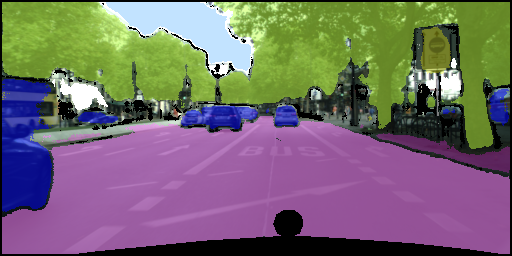

In [17]:
#### ---------------------------------------------------####
#### Results after training for 66 iterations on Test Image (data not seen before by the model)
#### ---------------------------------------------------####
infer_segments(test_image, im_softmax66, labels_Segments, image_shape)#66

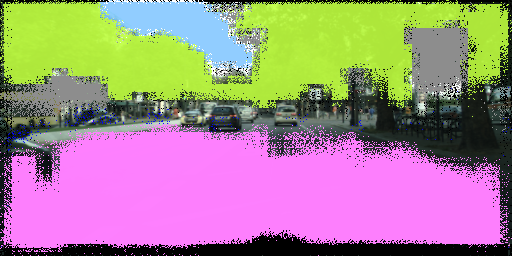

In [15]:
#### ---------------------------------------------------####
#### Results after training for 1 iterations on Test Image (data not seen before by the model)
#### ---------------------------------------------------####
#### Image saved earlier

# The improvement is obvious, lets train more for better results

In [7]:
#### ---------------------------------------------------####
#### Restore the last saved checkpoints to continue training for another 75 epochs
#### ---------------------------------------------------####
train_loss_list2 = []
valid_loss_list2 = []

num_classes = 29
image_shape = (256, 512)

data_dir = 'resized_dataset/'
label_dir = 'resized_labels/'


batch_size = 32
loader = tf.train.import_meta_graph('saved_models/e71.ckpt.meta')


with tf.Session() as sess:

    loader.restore(sess, tf.train.latest_checkpoint('./saved_models/'))
    
    train_op = tf.get_collection("optimizer")[0]
    
    graph = tf.get_default_graph()
    restored_logits = graph.get_tensor_by_name("logits:0")
    image_input = graph.get_tensor_by_name('image_input:0')
    keep_prob = graph.get_tensor_by_name('keep_prob:0')
    correct_label = graph.get_tensor_by_name('correct_label:0')
    
    labels_reshaped = tf.reshape(correct_label, (-1, num_classes))
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=restored_logits, labels= labels_reshaped))

    kp_pr = 0.5

    try:
        saver
    except NameError:
        saver = tf.train.Saver()
        
    get_batches_fn = gen_batch_function(os.path.join(data_dir, 'train'), os.path.join(label_dir, 'train'), labels_Segments)
    get_batches_fn_valid = gen_batch_function(os.path.join(data_dir, 'val'), os.path.join(label_dir, 'val'), labels_Segments)

    
    for i in range(75,151): # it should really be range(72, 151)
        mean_train_loss = 0
        m_train = 0
        tic = time.time()
        for images, labels in get_batches_fn(batch_size):
            _, train_loss = sess.run([train_op, cross_entropy_loss], 
                                     feed_dict ={image_input:images,correct_label:labels, 
                                                 keep_prob:kp_pr})
            mean_train_loss += train_loss * images.shape[0]
            m_train +=  images.shape[0]
            print("*     Train cost =", "{:.9f}".format(train_loss))
        mean_train_loss /= m_train
        train_loss_list.append(mean_train_loss)
        print("Training Epoch:", '%04d | ' % (i+1), "cost =", "{:.9f}".format(mean_train_loss))
        toc = time.time()
        print(toc-tic)
        
        
        ###----------------------------
        ###Validation
        ###----------------------------
        mean_valid_loss = 0
        m_valid = 0
        tic = time.time()
        for images, labels in get_batches_fn_valid(batch_size):
            valid_loss = sess.run([cross_entropy_loss], feed_dict ={image_input:images, correct_label:labels, keep_prob:kp_pr})
            mean_valid_loss += valid_loss[0] * images.shape[0]
            m_valid +=  images.shape[0]
        mean_valid_loss /= m_valid
        valid_loss_list.append(mean_valid_loss)
        print("Validation Epoch:", '%04d | ' % (i+1), "cost =", "{:.9f}".format(mean_valid_loss))
        toc = time.time()
        print(toc-tic)

        if i % 5 == 0:
            checkpoint = '{}/e{}.ckpt'.format('saved_models', i+1)
            saver.save(sess, checkpoint)
            print("Checkpoint saved for epoch "+str(i+1))
            
        
    tf.train.write_graph(sess.graph_def,'saved_models_pb150/','FCNVGG.pb', as_text=False)
    saver.save(sess, 'saved_models_pb150/FCNVGG')    
        

INFO:tensorflow:Restoring parameters from ./saved_models/e71.ckpt
*     Train cost = 0.160449088
*     Train cost = 0.144278944
*     Train cost = 0.162478775
*     Train cost = 0.142083317
*     Train cost = 0.157782674
*     Train cost = 0.159759045
*     Train cost = 0.145706758
*     Train cost = 0.147432119
*     Train cost = 0.164264634
*     Train cost = 0.157065064
*     Train cost = 0.150456235
*     Train cost = 0.153299794
*     Train cost = 0.152267277
*     Train cost = 0.146529347
*     Train cost = 0.149638891
*     Train cost = 0.152948186
*     Train cost = 0.160792530
*     Train cost = 0.148688093
*     Train cost = 0.157788128
*     Train cost = 0.159067556
*     Train cost = 0.159538999
*     Train cost = 0.156856656
*     Train cost = 0.149782240
*     Train cost = 0.153699055
*     Train cost = 0.158226967
*     Train cost = 0.143877909
*     Train cost = 0.163941830
*     Train cost = 0.150746047
*     Train cost = 0.158483446
*     Train cost = 0.147430912
*   

*     Train cost = 0.152954534
*     Train cost = 0.139199287
*     Train cost = 0.157770649
*     Train cost = 0.151266187
*     Train cost = 0.149936780
*     Train cost = 0.152297705
*     Train cost = 0.141094297
*     Train cost = 0.155009449
*     Train cost = 0.137030616
*     Train cost = 0.152301431
*     Train cost = 0.154973477
*     Train cost = 0.151166275
*     Train cost = 0.140885323
*     Train cost = 0.159594625
*     Train cost = 0.148971707
*     Train cost = 0.161012650
*     Train cost = 0.147320211
*     Train cost = 0.169244751
*     Train cost = 0.147855505
*     Train cost = 0.159805909
*     Train cost = 0.138606891
*     Train cost = 0.158742413
*     Train cost = 0.150034472
*     Train cost = 0.154901877
*     Train cost = 0.162144616
Training Epoch: 0078 |  cost = 0.152143293
552.7672204971313
Validation Epoch: 0078 |  cost = 0.799873859
85.88295197486877
*     Train cost = 0.151420206
*     Train cost = 0.155582801
*     Train cost = 0.148608118
*     Tr

*     Train cost = 0.155724704
*     Train cost = 0.160292745
*     Train cost = 0.141325980
*     Train cost = 0.153326154
*     Train cost = 0.145023972
*     Train cost = 0.136934370
*     Train cost = 0.153531343
*     Train cost = 0.150100976
*     Train cost = 0.146378994
*     Train cost = 0.152681559
*     Train cost = 0.144557908
*     Train cost = 0.156817168
*     Train cost = 0.152582064
*     Train cost = 0.150682658
*     Train cost = 0.150544330
*     Train cost = 0.153408527
*     Train cost = 0.152365386
*     Train cost = 0.151902825
*     Train cost = 0.160026044
*     Train cost = 0.141411304
*     Train cost = 0.133184746
*     Train cost = 0.136180446
*     Train cost = 0.134935915
*     Train cost = 0.139579028
*     Train cost = 0.155469939
*     Train cost = 0.146167219
*     Train cost = 0.146471471
*     Train cost = 0.144678518
*     Train cost = 0.153023690
*     Train cost = 0.147738963
*     Train cost = 0.155607209
*     Train cost = 0.149335772
*     Tr

*     Train cost = 0.138315231
*     Train cost = 0.141202271
*     Train cost = 0.156928509
*     Train cost = 0.152717441
*     Train cost = 0.141711310
*     Train cost = 0.149041280
*     Train cost = 0.146004885
*     Train cost = 0.133512080
*     Train cost = 0.129462540
*     Train cost = 0.140885457
*     Train cost = 0.146542311
*     Train cost = 0.142225072
*     Train cost = 0.149474114
*     Train cost = 0.160070837
*     Train cost = 0.134748399
*     Train cost = 0.147275060
*     Train cost = 0.147091225
*     Train cost = 0.145886391
*     Train cost = 0.145854205
*     Train cost = 0.139241099
*     Train cost = 0.147315949
*     Train cost = 0.153783023
*     Train cost = 0.152278304
*     Train cost = 0.151552647
*     Train cost = 0.141180933
*     Train cost = 0.144101799
*     Train cost = 0.142406046
*     Train cost = 0.144685164
*     Train cost = 0.146813601
*     Train cost = 0.149621010
*     Train cost = 0.130622298
*     Train cost = 0.143022791
*     Tr

*     Train cost = 0.161509782
*     Train cost = 0.155389503
*     Train cost = 0.141425803
*     Train cost = 0.144951314
*     Train cost = 0.136697233
*     Train cost = 0.136019289
*     Train cost = 0.139930710
Training Epoch: 0086 |  cost = 0.144176969
534.4742031097412
Validation Epoch: 0086 |  cost = 0.811955936
82.02421307563782
Checkpoint saved for epoch 86
*     Train cost = 0.135459036
*     Train cost = 0.137262687
*     Train cost = 0.143674359
*     Train cost = 0.130095914
*     Train cost = 0.147813275
*     Train cost = 0.156230703
*     Train cost = 0.137755394
*     Train cost = 0.147966191
*     Train cost = 0.130578488
*     Train cost = 0.141008541
*     Train cost = 0.139036894
*     Train cost = 0.152871311
*     Train cost = 0.138885379
*     Train cost = 0.145302758
*     Train cost = 0.126842588
*     Train cost = 0.146120012
*     Train cost = 0.137307867
*     Train cost = 0.154427961
*     Train cost = 0.139793843
*     Train cost = 0.140424535
*     Tra

*     Train cost = 0.142792374
*     Train cost = 0.146272376
*     Train cost = 0.144563615
*     Train cost = 0.138860628
*     Train cost = 0.148205504
*     Train cost = 0.153037220
*     Train cost = 0.141635254
*     Train cost = 0.143998459
*     Train cost = 0.145590529
*     Train cost = 0.143582672
*     Train cost = 0.140389487
*     Train cost = 0.125886232
*     Train cost = 0.144284278
*     Train cost = 0.126110539
*     Train cost = 0.135975599
*     Train cost = 0.135632545
*     Train cost = 0.139342532
*     Train cost = 0.147003710
*     Train cost = 0.141483963
*     Train cost = 0.117125943
*     Train cost = 0.145324245
*     Train cost = 0.131310776
*     Train cost = 0.138066351
*     Train cost = 0.146232605
*     Train cost = 0.136897102
*     Train cost = 0.138380304
*     Train cost = 0.151153907
*     Train cost = 0.147666246
*     Train cost = 0.149576247
*     Train cost = 0.143860847
*     Train cost = 0.156273931
*     Train cost = 0.161758363
*     Tr

*     Train cost = 0.140200853
*     Train cost = 0.136148542
*     Train cost = 0.139899403
*     Train cost = 0.143879145
*     Train cost = 0.137991592
*     Train cost = 0.141890928
*     Train cost = 0.128185570
*     Train cost = 0.132966831
*     Train cost = 0.142684057
*     Train cost = 0.152918518
*     Train cost = 0.141515002
*     Train cost = 0.131631702
*     Train cost = 0.145364985
*     Train cost = 0.143619835
*     Train cost = 0.147504807
*     Train cost = 0.138777062
*     Train cost = 0.133681044
*     Train cost = 0.138308614
*     Train cost = 0.135845065
*     Train cost = 0.140220121
*     Train cost = 0.139969930
*     Train cost = 0.143828988
*     Train cost = 0.137815669
*     Train cost = 0.140630454
*     Train cost = 0.138643160
*     Train cost = 0.131866530
*     Train cost = 0.141258806
*     Train cost = 0.146765038
*     Train cost = 0.134179205
*     Train cost = 0.137486964
*     Train cost = 0.130768567
*     Train cost = 0.134355739
*     Tr

*     Train cost = 0.129999802
*     Train cost = 0.153109640
*     Train cost = 0.134895310
*     Train cost = 0.135182709
*     Train cost = 0.137036607
*     Train cost = 0.137886107
*     Train cost = 0.136713147
*     Train cost = 0.129917666
*     Train cost = 0.155809999
*     Train cost = 0.143634856
*     Train cost = 0.135665715
*     Train cost = 0.122193448
*     Train cost = 0.139647603
*     Train cost = 0.127657056
*     Train cost = 0.140641481
*     Train cost = 0.124965072
*     Train cost = 0.120655440
*     Train cost = 0.141113162
*     Train cost = 0.128332093
*     Train cost = 0.124130309
*     Train cost = 0.132810026
*     Train cost = 0.145008683
*     Train cost = 0.130831093
*     Train cost = 0.140873238
*     Train cost = 0.155549601
*     Train cost = 0.121919967
*     Train cost = 0.139172137
*     Train cost = 0.117914438
*     Train cost = 0.133530676
*     Train cost = 0.130725816
*     Train cost = 0.137368456
*     Train cost = 0.138933703
*     Tr

*     Train cost = 0.138899639
*     Train cost = 0.130428344
*     Train cost = 0.138307840
*     Train cost = 0.131471664
*     Train cost = 0.137943208
*     Train cost = 0.129924566
*     Train cost = 0.128648743
*     Train cost = 0.133313835
*     Train cost = 0.131559283
*     Train cost = 0.125960037
*     Train cost = 0.139082655
*     Train cost = 0.138043195
*     Train cost = 0.138828129
*     Train cost = 0.124560557
*     Train cost = 0.140233532
*     Train cost = 0.130574524
*     Train cost = 0.127049997
Training Epoch: 0097 |  cost = 0.135469429
534.0918054580688
Validation Epoch: 0097 |  cost = 0.822619072
82.1883635520935
*     Train cost = 0.128510684
*     Train cost = 0.123999037
*     Train cost = 0.122181684
*     Train cost = 0.142395288
*     Train cost = 0.145704225
*     Train cost = 0.142441139
*     Train cost = 0.134271637
*     Train cost = 0.130108625
*     Train cost = 0.131751776
*     Train cost = 0.129348338
*     Train cost = 0.128533617
*     Tra

*     Train cost = 0.130538106
*     Train cost = 0.130103886
*     Train cost = 0.133158535
*     Train cost = 0.138921186
*     Train cost = 0.128449649
*     Train cost = 0.134986401
*     Train cost = 0.135945231
*     Train cost = 0.154360548
*     Train cost = 0.135812163
*     Train cost = 0.134399474
*     Train cost = 0.137267590
*     Train cost = 0.137858450
*     Train cost = 0.141393661
*     Train cost = 0.146021172
*     Train cost = 0.120210774
*     Train cost = 0.130882367
*     Train cost = 0.136449531
*     Train cost = 0.124376833
*     Train cost = 0.130324915
*     Train cost = 0.126953095
*     Train cost = 0.124298617
*     Train cost = 0.138958380
*     Train cost = 0.137300983
*     Train cost = 0.126327246
*     Train cost = 0.133892491
*     Train cost = 0.138958007
*     Train cost = 0.128297910
*     Train cost = 0.136351004
*     Train cost = 0.148431569
*     Train cost = 0.129245102
*     Train cost = 0.144276842
*     Train cost = 0.132705972
*     Tr

*     Train cost = 0.130163714
*     Train cost = 0.122725472
*     Train cost = 0.134747833
*     Train cost = 0.132951573
*     Train cost = 0.125292093
*     Train cost = 0.132251471
*     Train cost = 0.123325281
*     Train cost = 0.122503504
*     Train cost = 0.132363379
*     Train cost = 0.135545775
*     Train cost = 0.135951847
*     Train cost = 0.126081347
*     Train cost = 0.130476564
*     Train cost = 0.128952712
*     Train cost = 0.124492817
*     Train cost = 0.130317613
*     Train cost = 0.138256624
*     Train cost = 0.129785419
*     Train cost = 0.126814231
*     Train cost = 0.139786929
*     Train cost = 0.125779375
*     Train cost = 0.124200799
*     Train cost = 0.134388924
*     Train cost = 0.133046269
*     Train cost = 0.127958998
*     Train cost = 0.123904452
*     Train cost = 0.131675869
*     Train cost = 0.120390251
*     Train cost = 0.134966612
*     Train cost = 0.117787793
*     Train cost = 0.134244055
*     Train cost = 0.123144522
*     Tr

Validation Epoch: 0105 |  cost = 0.887709575
82.14742922782898
*     Train cost = 0.147779554
*     Train cost = 0.138043761
*     Train cost = 0.124691039
*     Train cost = 0.130352169
*     Train cost = 0.120352827
*     Train cost = 0.122061215
*     Train cost = 0.127668321
*     Train cost = 0.129492715
*     Train cost = 0.131657392
*     Train cost = 0.131998956
*     Train cost = 0.138086364
*     Train cost = 0.125748664
*     Train cost = 0.130527824
*     Train cost = 0.128383100
*     Train cost = 0.118482858
*     Train cost = 0.136176303
*     Train cost = 0.139688015
*     Train cost = 0.128664151
*     Train cost = 0.131928116
*     Train cost = 0.133774757
*     Train cost = 0.115467966
*     Train cost = 0.124250367
*     Train cost = 0.122232400
*     Train cost = 0.130052909
*     Train cost = 0.142983556
*     Train cost = 0.142742664
*     Train cost = 0.129225865
*     Train cost = 0.124272428
*     Train cost = 0.118258178
*     Train cost = 0.120902024
*     T

*     Train cost = 0.131620124
*     Train cost = 0.120079339
*     Train cost = 0.117095746
*     Train cost = 0.119242996
*     Train cost = 0.128511578
*     Train cost = 0.129417077
*     Train cost = 0.123594806
*     Train cost = 0.125731632
*     Train cost = 0.127580404
*     Train cost = 0.113790877
*     Train cost = 0.124564581
*     Train cost = 0.135442629
*     Train cost = 0.125711873
*     Train cost = 0.114878327
*     Train cost = 0.139811903
*     Train cost = 0.127427056
*     Train cost = 0.131092742
*     Train cost = 0.117162965
*     Train cost = 0.138450488
*     Train cost = 0.129977137
*     Train cost = 0.133010507
*     Train cost = 0.128017694
*     Train cost = 0.123103932
*     Train cost = 0.130292773
*     Train cost = 0.116830610
Training Epoch: 0108 |  cost = 0.126169266
534.0533213615417
Validation Epoch: 0108 |  cost = 0.886889988
82.09948801994324
*     Train cost = 0.124895610
*     Train cost = 0.124951564
*     Train cost = 0.127071723
*     Tr

*     Train cost = 0.127111048
*     Train cost = 0.123264454
*     Train cost = 0.127758473
*     Train cost = 0.126119807
*     Train cost = 0.135500640
*     Train cost = 0.122177437
*     Train cost = 0.129342481
*     Train cost = 0.123764753
*     Train cost = 0.124893077
*     Train cost = 0.122470185
*     Train cost = 0.118407130
*     Train cost = 0.129270583
*     Train cost = 0.132836863
*     Train cost = 0.136018008
*     Train cost = 0.126263082
*     Train cost = 0.113750763
*     Train cost = 0.130265012
*     Train cost = 0.126375750
*     Train cost = 0.108214110
*     Train cost = 0.127746463
*     Train cost = 0.130099565
*     Train cost = 0.118832767
*     Train cost = 0.129367143
*     Train cost = 0.107790351
*     Train cost = 0.125403598
*     Train cost = 0.113042049
*     Train cost = 0.132138535
*     Train cost = 0.127780914
*     Train cost = 0.130318329
*     Train cost = 0.124445006
*     Train cost = 0.112882085
*     Train cost = 0.129918128
*     Tr

*     Train cost = 0.123389915
*     Train cost = 0.122025549
*     Train cost = 0.114709347
*     Train cost = 0.125075266
*     Train cost = 0.132695749
*     Train cost = 0.114540927
*     Train cost = 0.129253939
*     Train cost = 0.126706079
*     Train cost = 0.118524872
*     Train cost = 0.133901417
*     Train cost = 0.113265589
*     Train cost = 0.117272586
*     Train cost = 0.114002027
*     Train cost = 0.108776875
*     Train cost = 0.128965586
*     Train cost = 0.127741337
*     Train cost = 0.115687743
*     Train cost = 0.120915525
*     Train cost = 0.120714314
*     Train cost = 0.131863803
*     Train cost = 0.115610063
*     Train cost = 0.120992169
*     Train cost = 0.132469490
*     Train cost = 0.130119428
*     Train cost = 0.118661277
*     Train cost = 0.119619712
*     Train cost = 0.117584050
*     Train cost = 0.122752160
*     Train cost = 0.115443677
*     Train cost = 0.124614000
*     Train cost = 0.112095691
*     Train cost = 0.125924557
*     Tr

*     Train cost = 0.120305330
*     Train cost = 0.130566329
*     Train cost = 0.116645530
*     Train cost = 0.109852232
*     Train cost = 0.120760031
*     Train cost = 0.113286391
*     Train cost = 0.120010063
Training Epoch: 0116 |  cost = 0.121047789
546.780463218689
Validation Epoch: 0116 |  cost = 0.876992787
84.34111475944519
Checkpoint saved for epoch 116
*     Train cost = 0.133041084
*     Train cost = 0.119226761
*     Train cost = 0.131556228
*     Train cost = 0.112943888
*     Train cost = 0.124562040
*     Train cost = 0.117256656
*     Train cost = 0.114332244
*     Train cost = 0.122637562
*     Train cost = 0.119186722
*     Train cost = 0.116729371
*     Train cost = 0.111432701
*     Train cost = 0.121455513
*     Train cost = 0.125666738
*     Train cost = 0.119629860
*     Train cost = 0.111683466
*     Train cost = 0.120243810
*     Train cost = 0.110707864
*     Train cost = 0.129957765
*     Train cost = 0.119245462
*     Train cost = 0.123953573
*     Tra

*     Train cost = 0.119989045
*     Train cost = 0.114790127
*     Train cost = 0.122238532
*     Train cost = 0.119117811
*     Train cost = 0.112802923
*     Train cost = 0.124528147
*     Train cost = 0.128937542
*     Train cost = 0.119967952
*     Train cost = 0.116429187
*     Train cost = 0.126215026
*     Train cost = 0.107413337
*     Train cost = 0.125480428
*     Train cost = 0.116650321
*     Train cost = 0.124249823
*     Train cost = 0.111366153
*     Train cost = 0.112986349
*     Train cost = 0.121883884
*     Train cost = 0.125705287
*     Train cost = 0.116273209
*     Train cost = 0.112032160
*     Train cost = 0.123876274
*     Train cost = 0.123620972
*     Train cost = 0.121967457
*     Train cost = 0.113632761
*     Train cost = 0.117235884
*     Train cost = 0.122535810
*     Train cost = 0.124391958
*     Train cost = 0.117664449
*     Train cost = 0.118853942
*     Train cost = 0.115550421
*     Train cost = 0.124801621
*     Train cost = 0.119963549
*     Tr

*     Train cost = 0.109965198
*     Train cost = 0.105437070
*     Train cost = 0.122449361
*     Train cost = 0.121138260
*     Train cost = 0.131084889
*     Train cost = 0.124471977
*     Train cost = 0.113022685
*     Train cost = 0.112919599
*     Train cost = 0.122091040
*     Train cost = 0.109801196
*     Train cost = 0.106520846
*     Train cost = 0.129359931
*     Train cost = 0.125751913
*     Train cost = 0.122005843
*     Train cost = 0.121492490
*     Train cost = 0.122995548
*     Train cost = 0.120569117
*     Train cost = 0.104389682
*     Train cost = 0.118079200
*     Train cost = 0.116003431
*     Train cost = 0.117706060
*     Train cost = 0.118019305
*     Train cost = 0.122115359
*     Train cost = 0.121618368
*     Train cost = 0.119788803
*     Train cost = 0.106928274
*     Train cost = 0.114403017
*     Train cost = 0.111855015
*     Train cost = 0.119606480
*     Train cost = 0.120940529
*     Train cost = 0.113163255
*     Train cost = 0.111690477
*     Tr

*     Train cost = 0.117901735
*     Train cost = 0.122246459
*     Train cost = 0.127743512
*     Train cost = 0.109134689
*     Train cost = 0.119625233
*     Train cost = 0.114167184
*     Train cost = 0.121932156
*     Train cost = 0.107214063
*     Train cost = 0.112896077
*     Train cost = 0.110925719
*     Train cost = 0.124035627
*     Train cost = 0.110560372
*     Train cost = 0.104078703
*     Train cost = 0.110886313
*     Train cost = 0.113323510
*     Train cost = 0.114578769
*     Train cost = 0.114639096
*     Train cost = 0.119645201
*     Train cost = 0.114032052
*     Train cost = 0.117430225
*     Train cost = 0.117503792
*     Train cost = 0.111365385
*     Train cost = 0.117943592
*     Train cost = 0.104771316
*     Train cost = 0.107738681
*     Train cost = 0.120064646
*     Train cost = 0.111895144
*     Train cost = 0.102899902
*     Train cost = 0.105702743
*     Train cost = 0.119202308
*     Train cost = 0.110814184
*     Train cost = 0.111687489
*     Tr

*     Train cost = 0.103044190
*     Train cost = 0.116051860
*     Train cost = 0.127442360
*     Train cost = 0.101127028
*     Train cost = 0.114353858
*     Train cost = 0.125526726
*     Train cost = 0.122047916
*     Train cost = 0.115711868
*     Train cost = 0.119696334
*     Train cost = 0.115395360
*     Train cost = 0.119550936
*     Train cost = 0.105351806
*     Train cost = 0.109215967
*     Train cost = 0.120252267
*     Train cost = 0.114205740
*     Train cost = 0.115348853
*     Train cost = 0.111040682
Training Epoch: 0127 |  cost = 0.113878976
533.900162935257
Validation Epoch: 0127 |  cost = 0.898869785
82.41476345062256
*     Train cost = 0.117988706
*     Train cost = 0.109009862
*     Train cost = 0.110409081
*     Train cost = 0.113474146
*     Train cost = 0.114242956
*     Train cost = 0.130818605
*     Train cost = 0.113106221
*     Train cost = 0.113570780
*     Train cost = 0.128770769
*     Train cost = 0.116599753
*     Train cost = 0.123766631
*     Tra

*     Train cost = 0.113846160
*     Train cost = 0.098583877
*     Train cost = 0.128227726
*     Train cost = 0.105299428
*     Train cost = 0.108209744
*     Train cost = 0.108234070
*     Train cost = 0.116352707
*     Train cost = 0.107091367
*     Train cost = 0.108499341
*     Train cost = 0.110217705
*     Train cost = 0.119061962
*     Train cost = 0.108502172
*     Train cost = 0.115144216
*     Train cost = 0.115951389
*     Train cost = 0.122471072
*     Train cost = 0.112199843
*     Train cost = 0.118986562
*     Train cost = 0.117533460
*     Train cost = 0.119558945
*     Train cost = 0.114732474
*     Train cost = 0.107654013
*     Train cost = 0.110722601
*     Train cost = 0.116410367
*     Train cost = 0.120916754
*     Train cost = 0.112558760
*     Train cost = 0.119943254
*     Train cost = 0.112032607
*     Train cost = 0.122680038
*     Train cost = 0.110977508
*     Train cost = 0.114378646
*     Train cost = 0.114611283
*     Train cost = 0.117094643
*     Tr

*     Train cost = 0.105631053
*     Train cost = 0.116696939
*     Train cost = 0.106599152
*     Train cost = 0.103734493
*     Train cost = 0.110326894
*     Train cost = 0.118536480
*     Train cost = 0.110838279
*     Train cost = 0.105336718
*     Train cost = 0.102314875
*     Train cost = 0.110970661
*     Train cost = 0.112883240
*     Train cost = 0.122463711
*     Train cost = 0.106602669
*     Train cost = 0.108131565
*     Train cost = 0.113049313
*     Train cost = 0.116319872
*     Train cost = 0.109963566
*     Train cost = 0.109536797
*     Train cost = 0.113681599
*     Train cost = 0.111556873
*     Train cost = 0.112541482
*     Train cost = 0.114014380
*     Train cost = 0.106510609
*     Train cost = 0.109509557
*     Train cost = 0.109304510
*     Train cost = 0.111588962
*     Train cost = 0.114532337
*     Train cost = 0.116303653
*     Train cost = 0.114272058
*     Train cost = 0.096501455
*     Train cost = 0.103765152
*     Train cost = 0.112786300
*     Tr

Validation Epoch: 0135 |  cost = 0.894264552
82.10615563392639
*     Train cost = 0.104069099
*     Train cost = 0.114052549
*     Train cost = 0.111173555
*     Train cost = 0.113435626
*     Train cost = 0.106720351
*     Train cost = 0.109052390
*     Train cost = 0.104732975
*     Train cost = 0.112526000
*     Train cost = 0.102086604
*     Train cost = 0.113598630
*     Train cost = 0.110348582
*     Train cost = 0.111578211
*     Train cost = 0.112442791
*     Train cost = 0.110338271
*     Train cost = 0.101562023
*     Train cost = 0.110540941
*     Train cost = 0.113951027
*     Train cost = 0.115109645
*     Train cost = 0.113506958
*     Train cost = 0.117373556
*     Train cost = 0.109723166
*     Train cost = 0.111639708
*     Train cost = 0.100991875
*     Train cost = 0.111305520
*     Train cost = 0.121215478
*     Train cost = 0.100690730
*     Train cost = 0.105754726
*     Train cost = 0.105646618
*     Train cost = 0.106203780
*     Train cost = 0.108225904
*     T

*     Train cost = 0.108290538
*     Train cost = 0.098692194
*     Train cost = 0.099843778
*     Train cost = 0.114792630
*     Train cost = 0.104027994
*     Train cost = 0.104102217
*     Train cost = 0.108632371
*     Train cost = 0.110081285
*     Train cost = 0.103975020
*     Train cost = 0.110238634
*     Train cost = 0.102652259
*     Train cost = 0.116872430
*     Train cost = 0.101275414
*     Train cost = 0.102119751
*     Train cost = 0.110801212
*     Train cost = 0.099644847
*     Train cost = 0.114454642
*     Train cost = 0.115408704
*     Train cost = 0.113524780
*     Train cost = 0.112238698
*     Train cost = 0.112334654
*     Train cost = 0.110461250
*     Train cost = 0.103066579
*     Train cost = 0.105815724
*     Train cost = 0.107642777
Training Epoch: 0138 |  cost = 0.108242038
534.7474739551544
Validation Epoch: 0138 |  cost = 0.914180432
82.13321042060852
*     Train cost = 0.112479538
*     Train cost = 0.111826591
*     Train cost = 0.113766596
*     Tr

*     Train cost = 0.103992388
*     Train cost = 0.105230689
*     Train cost = 0.110144340
*     Train cost = 0.113521405
*     Train cost = 0.102624655
*     Train cost = 0.106751367
*     Train cost = 0.096494570
*     Train cost = 0.110805921
*     Train cost = 0.109987713
*     Train cost = 0.104690522
*     Train cost = 0.101129159
*     Train cost = 0.102579407
*     Train cost = 0.105335891
*     Train cost = 0.113884538
*     Train cost = 0.109253116
*     Train cost = 0.128999934
*     Train cost = 0.104494594
*     Train cost = 0.105463669
*     Train cost = 0.099179082
*     Train cost = 0.109476343
*     Train cost = 0.112122357
*     Train cost = 0.107696809
*     Train cost = 0.106402434
*     Train cost = 0.113545336
*     Train cost = 0.107374869
*     Train cost = 0.100808889
*     Train cost = 0.098912008
*     Train cost = 0.117206387
*     Train cost = 0.105755813
*     Train cost = 0.108545236
*     Train cost = 0.109971248
*     Train cost = 0.109666854
*     Tr

*     Train cost = 0.104989745
*     Train cost = 0.115229651
*     Train cost = 0.110549003
*     Train cost = 0.106919743
*     Train cost = 0.113982625
*     Train cost = 0.099414669
*     Train cost = 0.097165436
*     Train cost = 0.101692200
*     Train cost = 0.110471055
*     Train cost = 0.109789498
*     Train cost = 0.100729786
*     Train cost = 0.109748267
*     Train cost = 0.110937916
*     Train cost = 0.108477585
*     Train cost = 0.108518459
*     Train cost = 0.115003929
*     Train cost = 0.115139276
*     Train cost = 0.111152634
*     Train cost = 0.102733046
*     Train cost = 0.102395549
*     Train cost = 0.106068857
*     Train cost = 0.101392992
*     Train cost = 0.098915398
*     Train cost = 0.103007101
*     Train cost = 0.106234685
*     Train cost = 0.113678619
*     Train cost = 0.103940994
*     Train cost = 0.110985287
*     Train cost = 0.109956801
*     Train cost = 0.102211848
*     Train cost = 0.107113995
*     Train cost = 0.107609041
*     Tr

*     Train cost = 0.110021621
*     Train cost = 0.110623330
*     Train cost = 0.102027595
*     Train cost = 0.101548344
*     Train cost = 0.113457203
*     Train cost = 0.108682834
*     Train cost = 0.105394408
Training Epoch: 0146 |  cost = 0.105227196
534.7367238998413
Validation Epoch: 0146 |  cost = 0.933189279
82.23540306091309
Checkpoint saved for epoch 146
*     Train cost = 0.117322505
*     Train cost = 0.105690651
*     Train cost = 0.103742614
*     Train cost = 0.099378407
*     Train cost = 0.104286522
*     Train cost = 0.115965620
*     Train cost = 0.101345815
*     Train cost = 0.102968909
*     Train cost = 0.101011164
*     Train cost = 0.104974031
*     Train cost = 0.100264788
*     Train cost = 0.100037627
*     Train cost = 0.104091324
*     Train cost = 0.103022560
*     Train cost = 0.106393650
*     Train cost = 0.107205212
*     Train cost = 0.115464516
*     Train cost = 0.106808648
*     Train cost = 0.108785048
*     Train cost = 0.099008396
*     Tr

*     Train cost = 0.097884662
*     Train cost = 0.104406409
*     Train cost = 0.103634216
*     Train cost = 0.098206803
*     Train cost = 0.100686371
*     Train cost = 0.105578616
*     Train cost = 0.101632066
*     Train cost = 0.100409850
*     Train cost = 0.108743399
*     Train cost = 0.095487431
*     Train cost = 0.103313297
*     Train cost = 0.107665986
*     Train cost = 0.105671093
*     Train cost = 0.108293429
*     Train cost = 0.102716237
*     Train cost = 0.101643622
*     Train cost = 0.105393752
*     Train cost = 0.104919843
*     Train cost = 0.104991436
*     Train cost = 0.108012751
*     Train cost = 0.110034630
*     Train cost = 0.110072941
*     Train cost = 0.105862789
*     Train cost = 0.103327431
*     Train cost = 0.104626507
*     Train cost = 0.110281147
*     Train cost = 0.094043128
*     Train cost = 0.104188874
*     Train cost = 0.107877038
*     Train cost = 0.104048699
*     Train cost = 0.117191613
*     Train cost = 0.108361423
*     Tr

In [ ]:
#### ---------------------------------------------------####
#### Restore one of the last saved checkpoints (151 in this case) to see the result
#### ---------------------------------------------------####
image_shape = (256, 512)
 
with tf.Session() as sess:

    saver = tf.train.import_meta_graph('saved_models/e151.ckpt.meta')
    saver.restore(sess, './saved_models/e151.ckpt')

    graph = tf.get_default_graph()
    restored_logits = graph.get_tensor_by_name("logits:0")
    image_input = graph.get_tensor_by_name('image_input:0')
    keep_prob = graph.get_tensor_by_name('keep_prob:0')

    #load a test image
    test_image = 'resized_dataset/test/berlin/berlin_000000_000019_leftImg8bit.png'
    test_image = scipy.misc.imresize(scipy.misc.imread(test_image), image_shape)

    im_softmax151 = sess.run([tf.nn.softmax(restored_logits)], feed_dict={image_input: np.array([test_image]), keep_prob:1.0 })


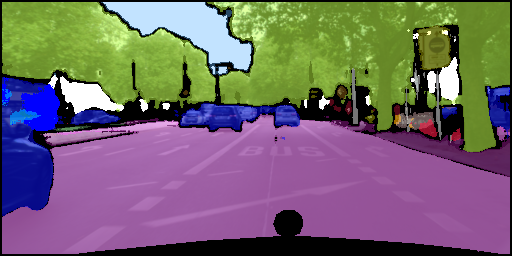

In [13]:
infer_segments(test_image, im_softmax151, labels_Segments, image_shape)#150

# This result looks even better

## Now optimize model for inference by using by freze_graph and optimize_for_inference methods

In [ ]:
#### ---------------------------------------------------####
#### Run the following in terminal, running them here won't work
#### ---------------------------------------------------####

#python -m tensorflow.python.tools.freeze_graph --input_graph FCNVGG.pb --input_checkpoint FCNVGG --output_graph FCNVGG_graph_frozen.pb --output_node_names=logits --input_binary=true
python3 -m tensorflow.python.tools.freeze_graph --input_graph FCNVGG.pb --input_checkpoint FCNVGG --output_graph FCNVGG_graph_frozen.pb --output_node_names=softmax --input_binary=true

#python -m tensorflow.python.tools.optimize_for_inference --input FCNVGG_graph_frozen.pb --output FCNVGG_graph_optimized.pb --input_names=image_input --output_names=logits
python3 -m tensorflow.python.tools.optimize_for_inference --input FCNVGG_graph_frozen.pb --output FCNVGG_graph_optimized.pb --input_names=image_input --output_names=softmax


In [7]:
#### ---------------------------------------------------####
#### Lets do inference on our optimized model to confirm results
#### ---------------------------------------------------####

image_shape = (256, 512)

test_image = 'resized_dataset/test/berlin/berlin_000000_000019_leftImg8bit.png'
test_image = scipy.misc.imresize(scipy.misc.imread(test_image), image_shape)

with tf.gfile.GFile('saved_models_pb/FCNVGG_graph_optimized.pb150', 'rb') as f:
   graph_def_optimized = tf.GraphDef()
   graph_def_optimized.ParseFromString(f.read())

G = tf.Graph()

with tf.Session(graph=G) as sess:
    restored_logits, = tf.import_graph_def(graph_def_optimized, return_elements=['softmax:0'])
    print('Operations in Optimized Graph:')
   
    input_image = G.get_tensor_by_name('import/image_input:0')
    keep_prob = G.get_tensor_by_name('import/keep_prob:0')
    
    #Due to the way the model was saved, we created a special layer for softmax and don't need to do it again.
    im_softmax = sess.run([(restored_logits)], feed_dict={input_image: [test_image], keep_prob:1.0 })


Operations in Optimized Graph:


## The optimized model was successfully restored and used for interence. Time to use it in a flask based webapp

# Misc Functions

In [ ]:
#### ---------------------------------------------------####
#### Resize all the data before to save time while training and for ease of download to AWS
#### ---------------------------------------------------####

# for path in  glob('../gtFine_trainvaltest/gtFine/**/*color.png', recursive=True):
#     directory = '../resized_labels/'+'/'.join(path.split('/')[3:-1])
#     name = (path.split('/')[-1])
#     try:
#         os.makedirs(directory)
#     except OSError as e:
#         if e.errno != errno.EEXIST:
#             raise
            
#     imgg = scipy.misc.imresize(scipy.misc.imread(path), image_shape)
    
#     scipy.misc.imsave(os.path.join(directory, name),imgg[:,:,:3])

# for path in  glob('../leftImg8bit_trainvaltest/leftImg8bit/**/*.png', recursive=True):
#     directory = '../resized_dataset/'+'/'.join(path.split('/')[3:-1])
#     name = (path.split('/')[-1])
#     try:
#         os.makedirs(directory)
#     except OSError as e:
#         if e.errno != errno.EEXIST:
#             raise
            
            
#     scipy.misc.imsave(os.path.join(directory, name),scipy.misc.imresize(scipy.misc.imread(path), image_shape))